In [3]:
# ---------------------------
# Step 1: Environment Setup
# ---------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from google.colab import files
from sklearn.metrics import classification_report

# Set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

# ---------------------------
# Step 2: Data Preparation
# ---------------------------
def prepare_data():
    # Define image transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load datasets
    train_val_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Split training into train/validation
    train_size = int(0.8 * len(train_val_data))
    train_data, val_data = random_split(train_val_data, [train_size, len(train_val_data)-train_size])

    # Create data loaders
    batch_size = 128
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [5]:

# ---------------------------
# Step 3: Model Definitions
# ---------------------------
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.layers(x)

class ConvolutionalNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [6]:
# ---------------------------
# Step 4: Training Process
# ---------------------------
def train_model(model, train_loader, val_loader, num_epochs=15):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Val Acc: {val_acc:.4f}')

    return history

In [7]:
# ---------------------------
# Step 5: Model Evaluation
# ---------------------------
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    # Visualize predictions
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        plt.title(f"True: {labels[i]}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [8]:
# ---------------------------
# Step 6: Deployment Setup
# ---------------------------
def preprocess_image(image_path):
    # Load and process image
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))

    # Enhance contrast and invert if needed
    img = ImageOps.autocontrast(img)
    img = Image.eval(img, lambda x: 0 if x < 64 else 255)
    if np.mean(img) > 127:
        img = Image.eval(img, lambda x: 255 - x)

    # Convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    return transform(img).unsqueeze(0).to(device)

def predict_digit(model, image_path):
    tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        _, prediction = torch.max(output, 1)
    return prediction.item()

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.56MB/s]


Training Fully Connected Network:
Epoch 1/15 | Train Loss: 0.2628 | Val Acc: 0.9563
Epoch 2/15 | Train Loss: 0.0988 | Val Acc: 0.9697
Epoch 3/15 | Train Loss: 0.0679 | Val Acc: 0.9771
Epoch 4/15 | Train Loss: 0.0445 | Val Acc: 0.9736
Epoch 5/15 | Train Loss: 0.0355 | Val Acc: 0.9759
Epoch 6/15 | Train Loss: 0.0299 | Val Acc: 0.9783
Epoch 7/15 | Train Loss: 0.0194 | Val Acc: 0.9757
Epoch 8/15 | Train Loss: 0.0233 | Val Acc: 0.9778
Epoch 9/15 | Train Loss: 0.0220 | Val Acc: 0.9762
Epoch 10/15 | Train Loss: 0.0161 | Val Acc: 0.9775
Epoch 11/15 | Train Loss: 0.0179 | Val Acc: 0.9746
Epoch 12/15 | Train Loss: 0.0176 | Val Acc: 0.9793
Epoch 13/15 | Train Loss: 0.0095 | Val Acc: 0.9770
Epoch 14/15 | Train Loss: 0.0104 | Val Acc: 0.9775
Epoch 15/15 | Train Loss: 0.0158 | Val Acc: 0.9743

Training Convolutional Network:
Epoch 1/15 | Train Loss: 0.1913 | Val Acc: 0.9801
Epoch 2/15 | Train Loss: 0.0514 | Val Acc: 0.9848
Epoch 3/15 | Train Loss: 0.0361 | Val Acc: 0.9882
Epoch 4/15 | Train Loss: 0.

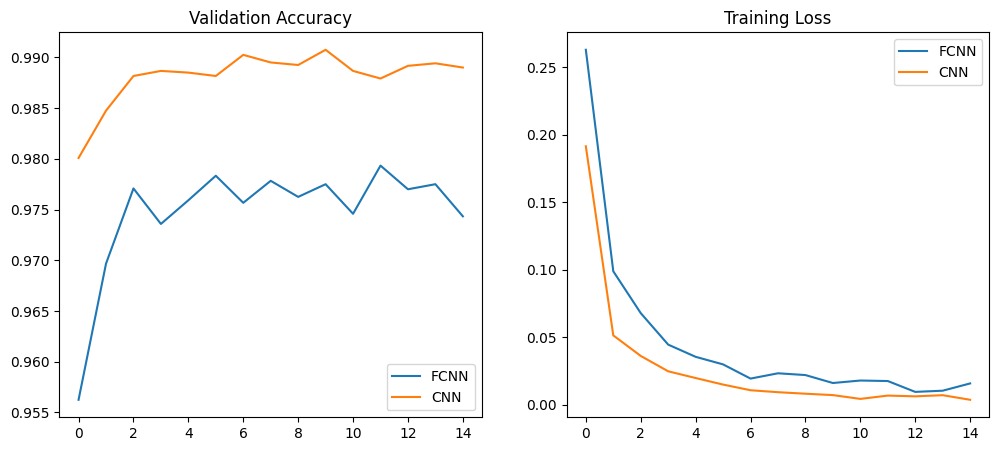


CNN Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0     0.9948    0.9786    0.9866       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9856    0.9932    0.9894      1032
           3     0.9960    0.9832    0.9895      1010
           4     0.9898    0.9857    0.9878       982
           5     0.9812    0.9922    0.9866       892
           6     0.9885    0.9885    0.9885       958
           7     0.9874    0.9912    0.9893      1028
           8     0.9969    0.9764    0.9865       974
           9     0.9671    0.9921    0.9795      1009

    accuracy                         0.9882     10000
   macro avg     0.9882    0.9880    0.9881     10000
weighted avg     0.9883    0.9882    0.9882     10000



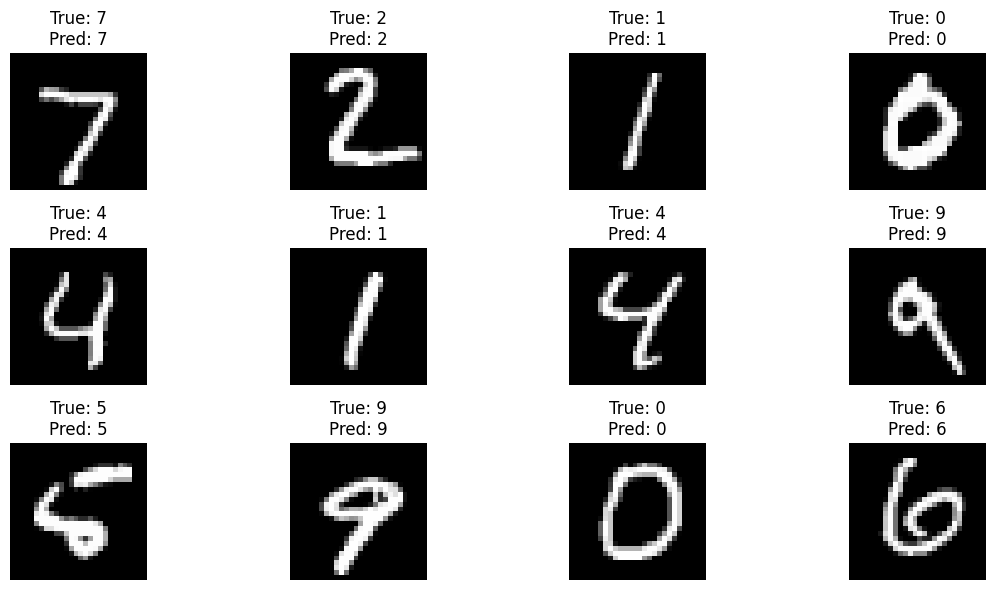

Saving resized_image_1.png to resized_image_1.png

Predicted Digit: 1


In [9]:
# ---------------------------
# Step 7: Execution Flow
# ---------------------------
if __name__ == "__main__":
    # Prepare data
    train_loader, val_loader, test_loader = prepare_data()

    # Initialize models
    fcnn = FullyConnectedNet()
    cnn = ConvolutionalNet()

    # Train models
    print("Training Fully Connected Network:")
    fcnn_history = train_model(fcnn, train_loader, val_loader)

    print("\nTraining Convolutional Network:")
    cnn_history = train_model(cnn, train_loader, val_loader)

    # Compare performance
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fcnn_history['val_acc'], label='FCNN')
    plt.plot(cnn_history['val_acc'], label='CNN')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fcnn_history['train_loss'], label='FCNN')
    plt.plot(cnn_history['train_loss'], label='CNN')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    # Evaluate best model
    print("\nCNN Evaluation:")
    evaluate_model(cnn, test_loader)

    # Save model
    torch.save(cnn.state_dict(), 'mnist_cnn.pth')

    # Deployment
    uploaded = files.upload()
    image_path = next(iter(uploaded))

    # Load saved model
    deployed_model = ConvolutionalNet().to(device)
    deployed_model.load_state_dict(torch.load('mnist_cnn.pth'))

    # Make prediction
    digit = predict_digit(deployed_model, image_path)
    print(f"\nPredicted Digit: {digit}")